<a href="https://colab.research.google.com/github/ikbenali/ReproducibilityProject_DL/blob/main/Poisson1DNTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import sympy as sm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

dtype  = torch.float32

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# device = torch.device('cpu')
sympyTorchmodules = {'sin': torch.sin, 'cos': torch.cos}


### 1D Poisson PDE Class

\begin{align}
u_{xx} &= f(x), \hspace{1.3cm} x \in \Omega \\
u(x) &= g(x), \hspace{1.3cm} x \in \partial \Omega
\end{align}

Where: 

\begin{align}
    f(x) &= -a^{2}\pi^{2}\sin(a\pi x), \hspace{0.2cm} x \in [0,1] \\
    g(x) &= 0, \hspace{2.3cm} x = 0,1
\end{align}

In [10]:
class Poisson1D:

    def __init__(self, a=None):

        self.setup_equations()
        self.setup_residuals()

        if a != None:
            self.a = 1

    def setup_equations(self, f_eqn=None, g_eqn=None):
        ### Setup

        # Variables/Coefficients
        a   = sm.symbols('a'); 

        # PDE States
        x   = sm.symbols('x')        # domain
        # xbc = sm.symbols('x1:3')   # partial domain for boundary condition

        u   = sm.symbols('u', cls=sm.Function)(x)
        ux  = u.diff(x)
        uxx = ux.diff(x)

        # Forcing/External/Boundary/Initial condition functions
        f   = sm.symbols('f', cls=sm.Function)(x)
        g   = sm.symbols('g', cls=sm.Function)(x)

        # Set up PDE_eqn
        self.PDE_eqn = sm.Eq(uxx,f)

        # Set up boundary condition
        # bc_eq1 = sm.Piecewise((u, sm.Eq(x, xbc[0])),  (u, sm.Eq(x, xbc[1])), (0, True))
        # bc_eq2 = sm.Piecewise((g, sm.Eq(x, xbc[0])),  (g, sm.Eq(x, xbc[1])), (0, True))
        self.BC_eqn  = sm.Eq(u, g)

        # For reuse in class
        self.x   = x 
        # self.xbc = xbc
        self.U = [u, ux, uxx]
        self.f = f 
        self.g = g 

    def setup_residuals(self):
        pde_residual = self.PDE_eqn.lhs - self.PDE_eqn.rhs
        bc_residual  = self.BC_eqn.lhs  - self.BC_eqn.rhs

        self.pde_residual = sm.lambdify([self.x, self.U, self.f], pde_residual, modules=sympyTorchmodules)
        self.bc_residual  = sm.lambdify([self.x, self.U, self.g], bc_residual,  modules=sympyTorchmodules)        

##### Define exact, source and boundary condition functions

In [11]:
def f_u_exact(a,x):
    """ 
    Exact solution
    """
    u_exact = torch.sin(a*torch.pi*x)

    return u_exact

def f_x(a, x):
    """
    Source/Forcing function
    """
    fx = -(a**2)*(torch.pi**2)*torch.sin(a*torch.pi*x)
       
    return fx

def g_x(x, xb):
    """
    Boundary condition
    """
    
    ub = torch.zeros(x.size(), dtype=dtype)

    xb1_idx = torch.where(x == xb[0])[0]
    xb2_idx = torch.where(x == xb[1])[0]

    ub[xb1_idx] = 0
    ub[xb2_idx] = 0

    return ub

#### PINN Class

In [12]:
class PINN(nn.Module):
    def __init__(self, input_size, output_size, neurons, PDE):
        super(PINN, self).__init__()

        # initialize values for nn
        self.xin        = input_size
        self.xout       = output_size
        self.neurons    = neurons

        # Define layers of network
        self.layer1     = nn.Linear(input_size, neurons)
        self.layer2     = nn.Linear(neurons, output_size)

        self.layers = [self.layer1, self.layer2]

        self.activation = nn.Tanh()      

        # import and initialize PDE
        if hasattr(PDE,'pde_residual'):
            self.pde_residual = PDE.pde_residual
        if hasattr(PDE, 'bc_residual'):
            self.bc_residual = PDE.bc_residual
        if hasattr(PDE, 'ic_residual'):
            self.ic_residual = PDE.ic_residual

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight.data)            
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):

        for layer in self.layers[:-1]:
            x = layer(x)
            x = self.activation(x)

        x = self.layers[-1](x)

        return x
    
    def backward(self, X, U, f=None, g=None, h=None):


        if X.shape[1] == 2:
            xr = X[:, 0].view(-1,1)
            xb = X[:, 1].view(-1,1)
        else:
            xr = xb = X

        if len(U.shape) == 3:
            U_x = U[0].T
            U_b = U[1].T
        else:
            U_x = U.T
            U_b = U.T

        loss = []

        if hasattr(self, 'pde_residual') and f != None:
            residual        = self.pde_residual(xr, U_x, f).T
            self.pde_loss   = torch.mean(residual**2)
        
            loss.append(self.pde_loss)

        if hasattr(self, 'bc_residual') and g !=None:
            residual        = self.bc_residual(xb, U_b, g).T
            self.bc_loss    = torch.mean(residual**2)
        
            loss.append(self.bc_loss)   

        if hasattr(self, 'ic_residual') and h != None:
            residual        = self.ic_residual(X, U, h).T
            self.ic_loss    = torch.mean(residual**2)
            loss.append(self.ic_loss)

        loss = torch.stack(loss, dim=0).sum()
        
        self.loss = loss

    def compute_NTK(self, X1, X2):

        # Get params of network
        params = {k: v for k, v in self.named_parameters()}


        PDE_K = False; BC_K = False

        if X1.shape[1] == 2 and X2.shape[1] == 2:
            xr1 = X1[:, 0].view(-1,1);   xb1 = X1[:, 1].view(-1,1)
            xr2 = X2[:, 0].view(-1,1);   xb2 = X2[:, 1].view(-1,1)

        else:
            xr1 = xb1 = X1
            xr2 = xb2 = X2

        if hasattr(self, 'pde_residual'):

            PDE_K = True;   

            f = torch.zeros(xr1.size(), device=device).T

            # forward pass points with current parameters and compute gradients w.r.t interior points
            u_hat_x1    = self.forward(xr1)
            ux_hat_x1   = torch.autograd.grad(u_hat_x1,  xr1, grad_outputs=torch.ones_like(u_hat_x1),  create_graph=True)[0]
            uxx_hat_x1  = torch.autograd.grad(ux_hat_x1, xr1, grad_outputs=torch.ones_like(ux_hat_x1), create_graph=True)[0]
            U_x1        = torch.hstack([u_hat_x1, ux_hat_x1, uxx_hat_x1]).T

            u_hat_x2    = self.forward(xr2)
            ux_hat_x2   = torch.autograd.grad(u_hat_x2,  xr2, grad_outputs=torch.ones_like(u_hat_x2),  create_graph=True)[0]
            uxx_hat_x2  = torch.autograd.grad(ux_hat_x2, xr2, grad_outputs=torch.ones_like(ux_hat_x2), create_graph=True)[0]
            U_x2        = torch.hstack([u_hat_x2, ux_hat_x2, uxx_hat_x2]).T
            
            L_u1   = self.pde_residual(xr1, U_x1, f).T.flatten()
            L_u2   = self.pde_residual(xr2, U_x2, f).T.flatten()

            L_u1.retain_grad()
            L_u2.retain_grad()

            n = self.neurons
            m = len(params)
            J_r_1 = torch.zeros((n,m), device=device)
            J_r_2 = torch.zeros((n,m), device=device)

            for i, layer_param in enumerate(params.keys()):
                theta    = params[layer_param].flatten()

                if theta.shape[0] == 1:
                    theta = torch.ones(L_u1.shape, device=device)*theta
                    theta[1:] = 0

                L_u1.backward(theta, retain_graph=True)
                L_u2.backward(theta, retain_graph=True)

                k = len(L_u1.grad)
                J_r_1[:k,i] = L_u1.grad
                J_r_2[:k,i] = L_u2.grad

                #end 

            self.K_rr       = torch.matmul(J_r_1, J_r_2.T)
            self.lambda_rr  = torch.trace(self.K_rr)

            #end

        if hasattr(self, 'bc_residual'):

            BC_K = True 
            g = torch.zeros(xb1.size(), device=device).T

            # forward pass points with current parameters and compute gradients w.r.t interior points
            u_hat_xb1    = self.forward(xb1)
            ux_hat_xb1   = torch.autograd.grad(u_hat_xb1,  xb1, grad_outputs=torch.ones_like(u_hat_xb1),  create_graph=True)[0]
            uxx_hat_xb1  = torch.autograd.grad(ux_hat_xb1, xb1, grad_outputs=torch.ones_like(ux_hat_xb1), create_graph=True)[0]
            U_xb1        = torch.hstack([u_hat_x1, ux_hat_x1, uxx_hat_xb1]).T

            u_hat_xb2    = self.forward(xb2)
            ux_hat_xb2   = torch.autograd.grad(u_hat_xb2,  xb2, grad_outputs=torch.ones_like(u_hat_xb2),  create_graph=True)[0]
            uxx_hat_xb2  = torch.autograd.grad(ux_hat_xb2, xb2, grad_outputs=torch.ones_like(ux_hat_xb2), create_graph=True)[0]
            U_xb2        = torch.hstack([u_hat_xb2, ux_hat_xb2, uxx_hat_xb2]).T
           
            u1   = self.bc_residual(xb1, U_xb1, g).T.flatten()
            u2   = self.bc_residual(xb2, U_xb2, g).T.flatten()

            u1.retain_grad()
            u2.retain_grad()

            n = self.neurons
            m = len(params)
            J_u_1 = torch.zeros((n,m), device=device)
            J_u_2 = torch.zeros((n,m), device=device)

            for i, layer_param in enumerate(params.keys()):
                theta    = params[layer_param].flatten()

                if theta.shape[0] == 1:
                    theta = torch.ones(L_u1.shape, device=device)*theta
                    theta[1:] = 0

                u1.backward(theta, retain_graph=True)
                u2.backward(theta, retain_graph=True)

                J_r_1[:,i] = u1.grad
                J_r_2[:,i] = u2.grad

                #end 

            self.K_uu       = torch.matmul(J_u_1, J_u_2.T)
            self.lambda_uu  = torch.trace(self.K_uu)

            #end
        if PDE_K and BC_K:
            K1 = torch.vstack((J_u_1,   J_r_1))
            K2 = torch.hstack((J_u_2.T, J_r_2.T))

            self.K = torch.matmul(K1, K2) 
            self.lambda_K = torch.trace(self.K)                   



## Run model

In [13]:
from torch.utils.data import DataLoader, RandomSampler

In [14]:
## Setup PDE Equation
a   = 2
PDE = Poisson1D(a)

# Define PDE domain
X_0,X_N = 0.,1.
X_bc  = [X_0, X_N]
# dx  = 0.002; # N   = int((X_N - X_0)/dx) 

N  = 500
Xr = torch.linspace(X_0, X_N, N, dtype=dtype, device=device, requires_grad=True).view(-1,1)
Xb = torch.randint(0, 2, (N,1),  dtype=dtype, device=device, requires_grad=True)

X  = torch.hstack((Xr, Xb))

In [15]:
## Setup PINN parameters

Nr      = 100
Nb      = 100
rand_sampler = RandomSampler(X, replacement=True)
XTrain       = DataLoader(X, Nr ,sampler=rand_sampler)

size          = len(XTrain.dataset)
learning_rate = 1e-5
epochs        = int(10e3)

loss_fn   = nn.MSELoss()
optimizer = optim.SGD

# net parameters
input_size  = 1
output_size = 1
neurons     = 100
net         = PINN(input_size, output_size, neurons, PDE)

optimizer = optimizer(net.parameters(), learning_rate)
# optimizer = optim.Adam(net.parameters(), learning_rate)

In [16]:
%%time

### TRAIN LOOP
train_losses = []

# NTK computation
compute_NTK          = True
compute_NTK_interval = 10
store_NTK    = True
eig_K        = []
eig_K_uu     = []
eig_K_rr     = []

# Auto Mixed Precision settings
use_amp = False
scaler  = torch.cuda.amp.GradScaler(enabled=use_amp)

for epoch in range(epochs+1):
    net.train()
    net.to(device)

    epoch_loss   = 0.0

    for i, x in enumerate(XTrain):
        xr = x[:,0].view(-1,1).to(device); xb = x[:,1].view(-1,1).to(device)

        ### INTERIOR DOMAIN
        # make prediction w.r.t. interior points

        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
            u_hat_x   = net(xr)
        
            # determine gradients w.r.t interior points
            ux_hat_x  = torch.autograd.grad(u_hat_x,  xr, grad_outputs=torch.ones_like(u_hat_x),  create_graph=True)[0]
            uxx_hat_x = torch.autograd.grad(ux_hat_x, xr, grad_outputs=torch.ones_like(ux_hat_x), create_graph=True)[0]
            U_x       = torch.hstack([u_hat_x, ux_hat_x, uxx_hat_x])

            # Compute forcing/source function
            fx = f_x(a, xr).T.to(device)

            ### BOUNDARY DOMAIN
            u_hat_xb    = net(xb)
            # determine gradients w.r.t boundary points
            ux_hat_xb   = torch.autograd.grad(u_hat_xb,  xb, grad_outputs=torch.ones_like(u_hat_xb),  create_graph=True)[0]
            uxx_hat_xb  = torch.autograd.grad(ux_hat_xb, xb, grad_outputs=torch.ones_like(ux_hat_xb), create_graph=True)[0]
            U_xb        = torch.hstack([u_hat_xb, ux_hat_xb, uxx_hat_xb])
            
            # compute boundary condition
            gx = g_x(xb, X_bc).T.to(device)

            U = torch.stack((U_x, U_xb), dim=0)

            ## Backward step
            net.backward(x, U, fx, gx)
            epoch_loss += net.loss.item()
            if i == len(XTrain) - 1:
                x_prime  = x.clone()
                U_prime  = U.clone()

        # Do optimisation step
        if use_amp:
            scaler.scale(net.loss).backward(retain_graph=True)
            scaler.step(optimizer)
            scaler.update()
        else:
            net.loss.backward(retain_graph=True)
            optimizer.step()
            
        optimizer.zero_grad()
        # END Batch loop

    # Compute NTK
    if epoch > 0:
        if (epoch % compute_NTK_interval == 0 or epoch == epochs - 1) and compute_NTK:

            net.compute_NTK(x, x_prime)
            if store_NTK:
                eig_K.append(net.lambda_K.item())
                eig_K_uu.append(net.lambda_uu.item())
                eig_K_rr.append(net.lambda_rr.item())


    train_losses.append(epoch_loss / len(XTrain))
    
    if epoch % 100 == 0 or epoch == epochs - 1: 
        print(f"Epoch: {epoch:4d}     loss: {train_losses[-1]:5f}")


Epoch:    0     loss: 772.897388
Epoch:  100     loss: 747.804602
Epoch:  200     loss: 787.954492
Epoch:  300     loss: 761.916724
Epoch:  400     loss: 792.172180
Epoch:  500     loss: 766.650391
Epoch:  600     loss: 777.911023
Epoch:  700     loss: 788.415515
Epoch:  800     loss: 793.574109
Epoch:  900     loss: 766.435254
Epoch: 1000     loss: 798.412952
Epoch: 1100     loss: 737.379346
Epoch: 1200     loss: 757.064197
Epoch: 1300     loss: 779.073950
Epoch: 1400     loss: 789.736292
Epoch: 1500     loss: 790.168811
Epoch: 1600     loss: 777.031787
Epoch: 1700     loss: 789.366760
Epoch: 1800     loss: 767.366138
Epoch: 1900     loss: 802.809155
Epoch: 2000     loss: 780.717041
Epoch: 2100     loss: 759.299133
Epoch: 2200     loss: 731.932837
Epoch: 2300     loss: 768.827417
Epoch: 2400     loss: 795.119836
Epoch: 2500     loss: 754.567554
Epoch: 2600     loss: 763.990503
Epoch: 2700     loss: 768.625623
Epoch: 2800     loss: 760.501025
Epoch: 2900     loss: 751.142749
Epoch: 300

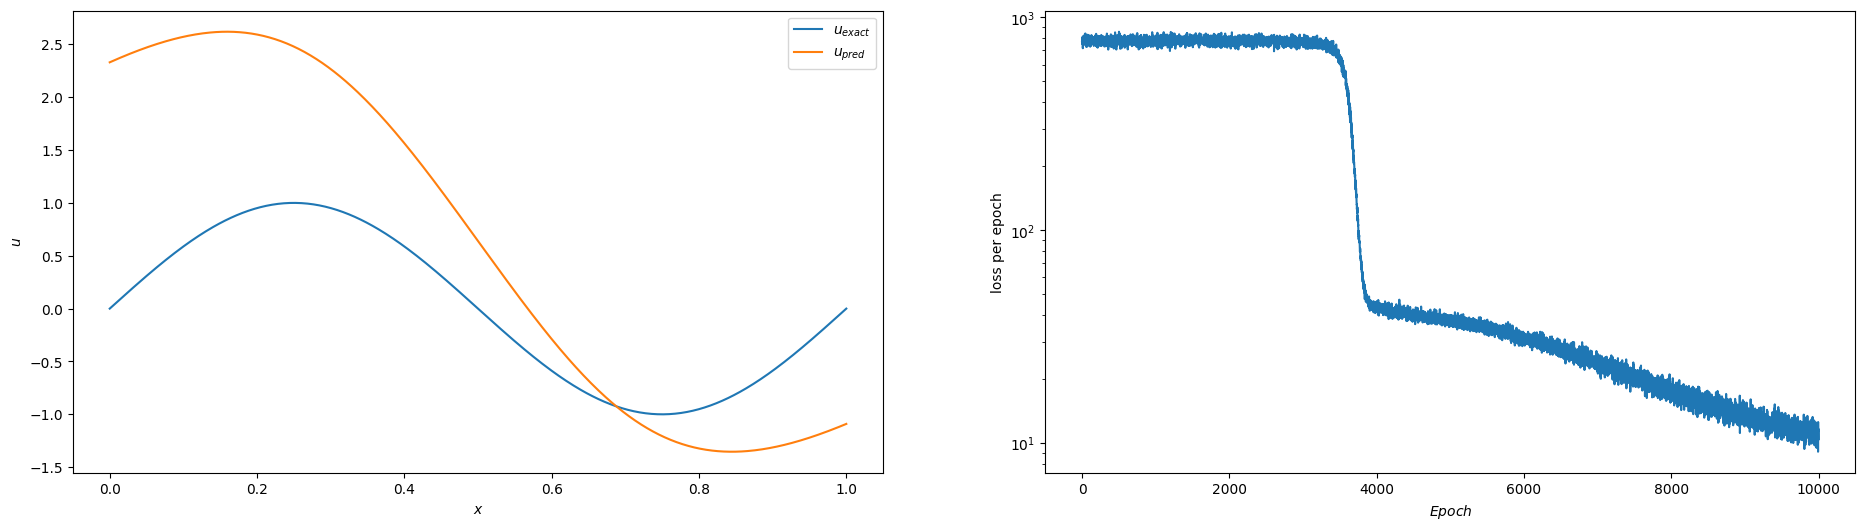

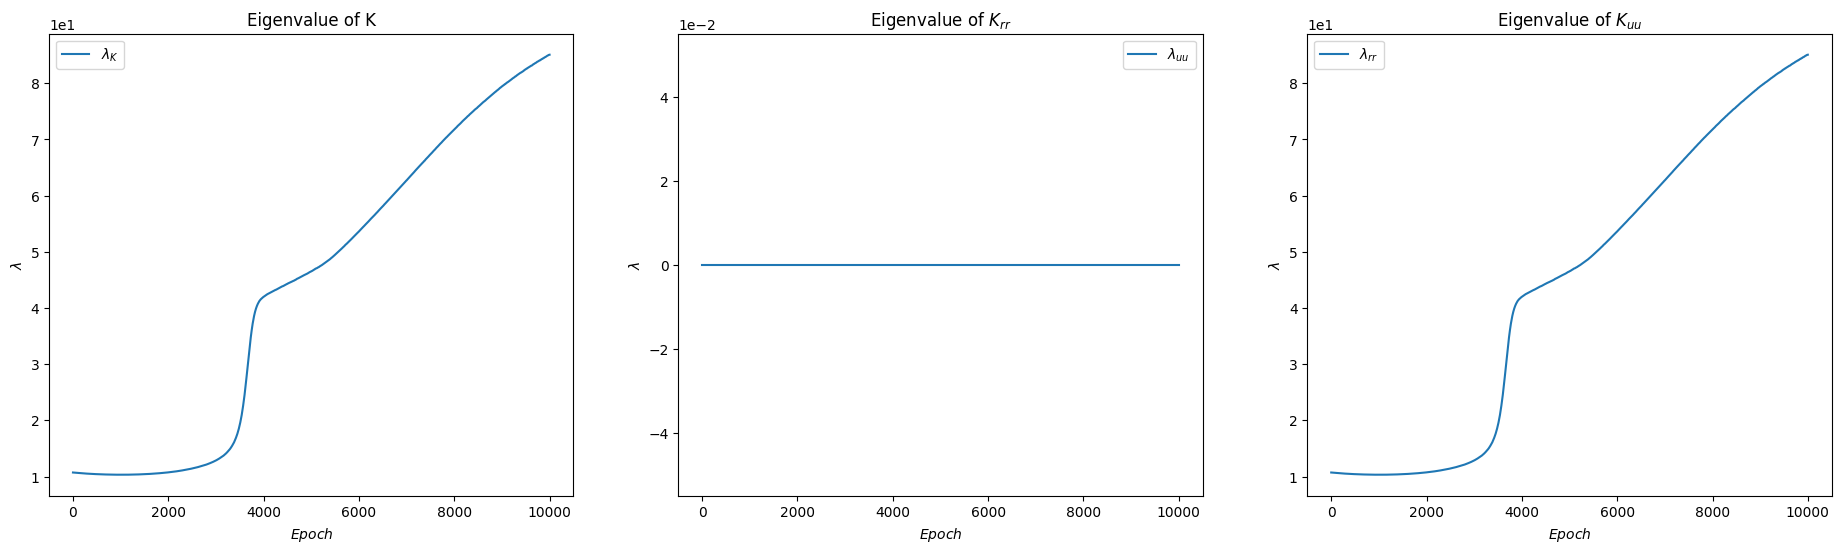

In [17]:
xplot = torch.linspace(X_0, X_N, N, requires_grad=True).view(-1,1).to(device)

# compute exact solution
u_exact = f_u_exact(a, xplot)
u_pred  = net(xplot)

xplot   = xplot.cpu().detach().numpy()
u_exact = u_exact.cpu().detach().numpy()
u_pred  = u_pred.cpu().detach().numpy()

### PLOT Prediction accuracy and training loss

fig, axs = plt.subplots(1,2, figsize=(23,6))

# predict
axs[0].plot(xplot, u_exact, label='$u_{exact}$')
axs[0].plot(xplot, u_pred, label='$u_{pred}$')
axs[0].legend()
axs[0].set_ylabel(r'$u$')
axs[0].set_xlabel(r'$x$')


axs[1].semilogy(train_losses)
axs[1].set_ylabel(r'loss per epoch')
axs[1].set_xlabel(r'$Epoch$')


if compute_NTK:
    ### PLOT Eigenvalue of NTK matrices
    fig, axs = plt.subplots(1,3, figsize=(23,6))

    NTK_index = torch.arange(0, epochs+compute_NTK_interval, compute_NTK_interval)

    axs[0].plot(NTK_index, eig_K,      label=r'$\lambda_{K}$');     axs[0].set_title('Eigenvalue of K')
    axs[1].plot(NTK_index, eig_K_uu,   label=r'$\lambda_{uu}$');    axs[1].set_title('Eigenvalue of {}'.format(r"$K_{rr}$"))
    axs[2].plot(NTK_index, eig_K_rr,   label=r'$\lambda_{rr}$');    axs[2].set_title('Eigenvalue of {}'.format(r"$K_{uu}$"))

    for ax in axs:
        ax.legend()
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax.set_ylabel(r'$\lambda$')
        ax.set_xlabel(r'$Epoch$')
    
plt.show()
